## Practical work in AI

1. Image preprocessing

The images are not sorted in the right way: can't figure out which domain belongs to which images.
I wrote a script to perform sorting based on the domain names that are present in the UNPROCESSED Retouch images.
Now, I have a list of dicts for the source images and a list of dicts for the target images.

2. Image augmentation

    Main problem currently: SVD is slow (0.6 seconds/image just for the decomposition!)
    the entire dataset in batches of 16, dataloading alone takes more than 5 minutes!

    

3. Training

    How many output channels does my network? 2? How many classes do I actually have? i guess 3, since in the paper they use 3 biomarkers
       

In [2]:
import numpy as np
import cv2
from pathlib import Path
import os
import glob
from tqdm.notebook import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from typing import Hashable, Optional, Union, Sequence
import scipy.ndimage
from typing import *
from monai.config.type_definitions import KeysCollection
from PIL import Image

import monai
from monai.networks.nets import BasicUNetPlusPlus
from monai.transforms import *

import albumentations as A

import wandb

In [3]:
sample_img = '/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/data/RETOUCH/TrainingSet-Release/Cirrus/03a60d9078d35b1488e6030880a29014/reference.mhd'
itk_image = sitk.ReadImage(sample_img)
image_array = sitk.GetArrayViewFromImage(itk_image)

# print the image's dimensions
print("Size of certain input image: ", image_array.shape)
Path.cwd()

Size of certain input image:  (128, 1024, 512)


PosixPath('/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical')

In [4]:
name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/')
train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train')

In [5]:
data = {}
for device in os.listdir(name_dir):
    data[device] = os.listdir(name_dir / device)

for device, vals in data.items():
    print("Device: ", device, "; Number of folders: ", len(vals))

print("Preprocessed Retouch folders: ", len(os.listdir(train_dir)))

Device:  Topcon ; Number of folders:  22
Device:  Spectralis ; Number of folders:  24
Device:  Cirrus ; Number of folders:  24
Preprocessed Retouch folders:  70


In [6]:
import time

SOURCE_DOMAIN = 'Spectralis'
DOMAINS = ['Spectralis', 'Topcon', 'Cirrus']

'''
Below class does the following:
sort data and output one large list of dicts for all source images and one for all target images. Transforms are applied in the monai or torch
dataset classes. they don't need to be created.
'''

class OCTDatasetPreparation(Dataset):
    '''
    Custon dataset object accomplishes the task of bringing the training data into the right format for further processing.
    '''
    
    def __init__(self, data_path: str, transform: Sequence = None, generate_empty_labels=False, source_domain: str = 'Spectralis'):

        self.data_path = Path(data_path)
        self.named_domain_folder = Path.cwd() / 'data/RETOUCH/TrainingSet-Release' # path holding the img folders sorted by domain
        self.domains = os.listdir(self.named_domain_folder) # gets only the names of domains
        self.source_domain = source_domain

        self.transform = transform

        if generate_empty_labels:
            self.generate_black_images() # check if this misses arguments
                                         # change method so it only creates black images for source domain

        try:
            self.dict_domain_images_sorted, self.num_domains = self.filter_source_domain(self.data_path, self.source_domain, self.domains)
        except IndexError:
            raise Exception("LABEL IMAGES MISSING! Have you tried generating all missing label images?")

        self.source_domain_dict = self.dict_domain_images_sorted.pop(self.source_domain)
        self.target_domain_dict = self.dict_domain_images_sorted
        


    def __len__(self):
        return len(self.source_domain_dict)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.source_domain_dict[idx]
  
        sample['img'] = self.perform_SVDNA(sample['img'], self.target_domain_dict, self.domains, self.source_domain)
        sample['label'] = cv2.imread(sample['label'])

        if self.transform:
            sample = self.transform(sample)


        
        return sample
        
        
        
    def readIm(self, imagepath):
        image = cv2.imread(str(imagepath),0)
        return image
        
    def svdna(self, k, target_path, src_path, histo_matching_degree=0.5):

        # resizing making problems, because the images are not square.
        # what image size should I use? Why do I even need to resize?
        h, w = 1024, 496
        # open images
        target_img = Image.open(target_path).convert("L")
        src_img = Image.open(src_path).convert("L")

        # resize them to the same size
        resized_target=np.array(target_img.resize((h, w), Image.NEAREST))
        resized_src=np.array(src_img.resize((h, w), Image.NEAREST))

        # perform SVD
        start_time = time.time()
        
        u_target, s_target, vh_target=np.linalg.svd(resized_target, full_matrices=False)
        u_source, s_source, vh_source=np.linalg.svd(resized_src, full_matrices=False)

        print("SVD took: ", time.time()-start_time, " seconds")

        # we're only getting the "noise" from the target (the first k singular values are not needed)
        thresholded_singular_target=s_target
        thresholded_singular_target[0:k]=0

        thresholded_singular_source=s_source
        thresholded_singular_source[k:]=0

        target_style=np.array([np.dot(u_target, np.dot(np.diag(thresholded_singular_target), vh_target))])

        content_src=np.array([np.dot(u_source, np.dot(np.diag(thresholded_singular_source), vh_source))])
        content_trgt = resized_target - target_style

        noise_adapted_im = content_src + target_style

        noise_adapted_im_clipped = np.squeeze(noise_adapted_im).clip(0,255).astype(np.uint8)

        transformHist = A.Compose([
            A.HistogramMatching([target_path], blend_ratio=(histo_matching_degree, histo_matching_degree), read_fn=self.readIm, p=1)
        ])

        #image = np.array(Image.open(src_path).resize((IMAGE_SIZE,IMAGE_SIZE)))

        transformed = transformHist(image=noise_adapted_im_clipped)
        svdna_im = transformed["image"]

        # of all the returned images, only svdna_im is needed so far. svdna_im is the image that has been svdna'd
        return resized_src, resized_target, content_src, np.squeeze(target_style), svdna_im, noise_adapted_im_clipped


    def perform_SVDNA(self, img_path, target_dataset, domains, source_domain):
        '''
        Function takes an img from source domain and applied SVDNA to it.
        In order to do that, we have to sample 2 things for each picture:

        One of ['Spectralis', 'Topcon', 'Cirrus'] to know where to take the style from.
            if the source domain is chosen, no style transfer (i. e. svdna) is performed
        k some number between 20 and 50

        '''

        domain = np.random.choice(domains)

        if domain == source_domain:
            img = np.array(Image.open(img_path).convert("L").resize((1024, 496)))
            return img
        
        else:
            # randomly sample k and target image to get style from
            k = np.random.randint(20, 50)
            
            target_img_path = target_dataset[domain][np.random.randint(0, len(target_dataset[domain]))]['img']
            
            _, _, _, _, img_svdna, _ = self.svdna(k, target_img_path, img_path)
            
            return img_svdna



    def filter_source_domain(self, data_path, source_domain, domains):
        '''
        data_path: Path to the training set folder where all images are not sorted by domains.
        source_domain: The source domain for the upcoming SVDNA process.

        Returns: a dictionary containing three lists of dictionaries of the following structure:
                    {source domain: [{img: img1, label: label1}, {img: img2, label: label2}, ...], 
                    target domain 1: [{img: img1}, {img: img2}, ...],
                    target domain 2: [{img: img1}, {img: img2}, ...]}
        '''

        # creates dict e.g. {'cirrus':['path1', 'path2', ...], 'topcon':['path1', 'path2', ...]}
        img_folders_sorted_by_domain = {domain:os.listdir(self.named_domain_folder / domain) for domain in domains}


        # restructure source data into a list of dictionaries, where each dictionary has keys img and label

        unsorted_img_folders_training_set = os.listdir(data_path)

        domains_dict = {}

        for domain in domains:
            
            list_of_dicts_images = []
            
            for img_folder in unsorted_img_folders_training_set:

                if img_folder in img_folders_sorted_by_domain[domain]:
                    
                    subfolders = os.listdir(data_path / img_folder)
                    unsorted_img_folders_training_set.remove(img_folder)

                    if 'image' in subfolders and 'label_image' in subfolders:
                        
                        if domain == source_domain:
            
                            sliced_images = sorted(os.listdir(data_path / img_folder / 'image'))
                            sliced_labels = sorted(os.listdir(data_path / img_folder / 'label_image'))
                            
                            for i in range(len(sliced_images)):
                                if (sliced_images[i] == sliced_labels[i]) or (sliced_images[i][:-4] + '_empty.png' == sliced_labels[i]):
                                    list_of_dicts_images.append(
                                        {'img': str(data_path / img_folder / 'image' / sliced_images[i]), 'label': str(data_path / img_folder / 'label_image' / sliced_labels[i])}
                                        )

                                else:
                                    #print(f"Image {img_folder}/image/{sliced_images[i]} has no corresponding label image. Skipping image. \nTake a look at 'generate_black_images' method.") 
                                    continue
                        
                        else:

                            sliced_images = sorted(os.listdir(data_path / img_folder / 'image'))

                            for i in range(len(sliced_images)):
                                    list_of_dicts_images.append({'img': str(data_path / img_folder / 'image' / sliced_images[i])})
                        
            domains_dict[domain] = list_of_dicts_images
                                        
        return domains_dict, len(domains)

    def generate_black_images(self, delete_images=False):
        """
        Generate black images for missing files in the label_image folder.

        Args:
            main_folder (str or Path): Path to the main folder.
            delete_images (bool, optional): Flag to delete the generated black images. Defaults to False.
        """
        main_folder = self.data_path

        if not delete_images:
        # Iterate over the subfolders
            for subfolder in sorted(os.listdir(main_folder)):
                subfolder_path = main_folder / subfolder

                # Check if the subfolder contains the 'image' and 'label_image' folders
                if os.path.isdir(subfolder_path) and 'image' in os.listdir(subfolder_path) and 'label_image' in os.listdir(subfolder_path):
                    image_folder = subfolder_path / 'image'
                    label_folder = subfolder_path / 'label_image'

                    # Get the set of filenames in the 'image' folder
                    image_files = sorted(set(os.listdir(image_folder)))

                    # Get the set of filenames in the 'label_image' folder
                    label_files = sorted(set(os.listdir(label_folder)))

                    # Find the filenames that are in 'label_image' but not in 'image'
                    missing_files = [i for i in image_files if i not in label_files]

                    # Create a black image for each missing file
                    for file in missing_files:
                        file_path = label_folder / file

                        # find the shape of the input image to create corresponding target
                        file_shape = cv2.imread(str(image_folder / file)).shape
                        black_image = np.zeros(file_shape)

                        # make unique names so files can be deleted again
                        cv2.imwrite(f"{str(file_path)[:-4]}_empty.png", black_image)

        # Delete the generated black images if delete_images flag is True
        if delete_images:
            for subfolder in sorted(os.listdir(main_folder)):
                subfolder_path = main_folder / subfolder
                if os.path.isdir(subfolder_path) and 'label_image' in os.listdir(subfolder_path):
                    label_folder = subfolder_path / 'label_image'
                    for file in os.listdir(label_folder):
                        file_path = label_folder / file
                        if "_empty" in str(file):
                            os.remove(str(file_path))

    def delete_generated_labels(self):
        # Delete the generated black images
        self.generate_black_images(delete_images=True)


In [7]:
#sample_img = {'img':'/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/data/Retouch-Preprocessed/train/03a60d9078d35b1488e6030880a29014/image/006.png', 
#              'label':'/Users/moritz/Documents/Master/OPTIMA_Masterarbeit/practical/data/Retouch-Preprocessed/train/3c68f67cd2e2b41afa54bf6059f509d1/label_image/003_empty.png'}
#img = LoadImaged(keys=['img', 'label'])(sample_img)
#img['label'].shape

Number of domains:  3
Number of source images:  784
Number of target images:  4224


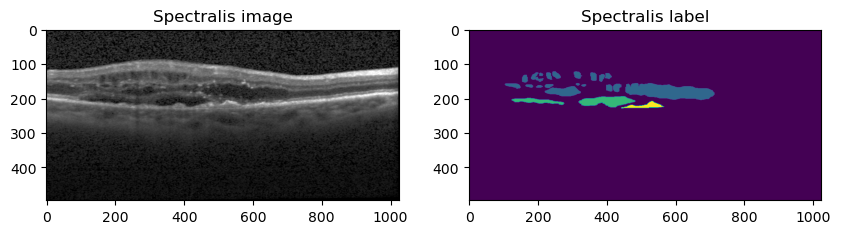

In [8]:
test_dataset_sorted = OCTDatasetPreparation(train_dir, generate_empty_labels=False, source_domain=SOURCE_DOMAIN)

print("Number of domains: ", test_dataset_sorted.num_domains)
print("Number of source images: ", len(test_dataset_sorted.source_domain_dict))
print("Number of target images: ", len(test_dataset_sorted.target_domain_dict['Cirrus']) + len(test_dataset_sorted.target_domain_dict['Topcon']))

# plot the first spectralis image and label
which_image = 10
img = cv2.imread(test_dataset_sorted.source_domain_dict[which_image]['img'], cv2.IMREAD_GRAYSCALE)
label = cv2.imread(test_dataset_sorted.source_domain_dict[which_image]['label'], cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Spectralis image')
ax[1].imshow(label, cmap='viridis')
ax[1].set_title('Spectralis label')
plt.show()

In [24]:
labels_mapping = {255: 0,
                  0: 1,
                  80: 2,
                  160: 3}


class ConvertToMultiChannelMasks(MapTransform):
    """
    Convert labels of ong image into 0,1,2,3
    0 - background
    1 - RNFL
    2 - GCIPL
    3 - Choroid
    """

    def __init__(self, keys: KeysCollection, target_keys: List[str], allow_missing_keys: bool = False) -> None:
        super().__init__(keys, allow_missing_keys)
        self.target_keys = target_keys


    def __call__(self, data):


        d = dict(data)
        for ki, key in enumerate(self.keys):

            mask = data[key]
            h, w= mask.shape

            mask_new = np.zeros((len(labels_mapping), h, w),dtype=np.uint8)
                      

            for i, (k, v) in enumerate(labels_mapping.items()):
                mask_new[i][mask==k] = 1

            d[self.target_keys[ki]] = mask_new[1:]
        return d
    

class ConvertToMultiChannelGOALS(MapTransform):
    """
    Convert labels of ong image into 0,1,2,3
    0 - background
    1 - RNFL
    2 - GCIPL
    3 - Choroid
    """

    def __call__(self, data):


        d = dict(data)
        for key in self.keys:

            mask = data[key]

            mask_new = np.zeros_like(mask,dtype=np.uint8)

            for k,v in labels_mapping.items():
                mask_new[mask==k] = v

            d[key] = mask_new 
        return d
    

class GetMaskPositions(MapTransform):
    def __init__(self, keys: KeysCollection, target_keys: List[str], allow_missing_keys: bool = False) -> None:
        super().__init__(keys, allow_missing_keys)
        self.target_keys = target_keys


    def __call__(self, data):


        d = dict(data)
        for ki, key in enumerate(self.keys):

            mask = data[key]
            num, h, w = mask.shape

            mask_positions = np.zeros((num * 2, w),dtype=np.float32)
                      

            for i in range(num):
                mask_positions[i*2] = np.argmax(mask[i], axis=0)
                mask_positions[i*2 + 1] = h - np.argmax(np.flip(mask[i], axis=0), axis=0)

            # The first and the second masks share a common border
            removal_mask = np.ones(len(mask_positions), dtype=bool)
            removal_mask[1] = False
            mask_positions = mask_positions[removal_mask]
            mask_positions = np.expand_dims(mask_positions, 1)
            d[self.target_keys[ki]] = mask_positions
            d["invalid_masks"] = np.ones_like(mask_positions)
        return d
    

class LayerPositionToProbabilityMap(MapTransform):
    def __init__(self, keys: Sequence, target_size, target_keys: Sequence = None):
        super().__init__(keys)
        if target_keys is None:
            self.target_keys = keys
        self.target_keys = target_keys
        self.target_size = target_size
    
    def smoothing_function(self, mask):
        mean = 0
        std = 0.5
        scale = 1 / (std * np.sqrt(2 * np.pi))
        return scale * np.exp(-(mask - mean)**2 / (2 * std**2))
        #return -(mask - mean)**2 / (2 * std**2)
        
    def __call__(self, data):
        for i, key in enumerate(self.keys):
            layer = data[key]
            column = np.arange(self.target_size[1])
            column = np.expand_dims(column, 1)
            mask = np.repeat(column, self.target_size[0], axis=1)
            mask = np.expand_dims(mask, 0)
            mask = np.repeat(mask, layer.shape[0], axis=0)
            #layer = np.expand_dims(layer, 1)
            #print(mask.shape, layer.shape)
            mask = mask - layer
            #mask = np.ones_like(mask)
            mask = mask.astype(np.float32)
            
            mask = self.smoothing_function(mask)
            mask = mask / np.expand_dims(mask.sum(axis=1), axis=2)
            data[self.target_keys[i]] = mask

        return data
    

class CropImages(MapTransform):

    def __init__(self, keys: KeysCollection, source_key : str, crop_size, crop_allowance=10, allow_missing_keys: bool = False) -> None:
        super().__init__(keys, allow_missing_keys)
        self.source_key = source_key
        self.crop_size = crop_size
        self.crop_allowance = crop_allowance


    def __call__(self, data):


        d = dict(data)
        for ki, key in enumerate(self.keys):
            preliminary = data[self.source_key]
            min_val = max(preliminary.min() - self.crop_allowance, 0)
            img = data[key]
            img_crop = img[:, min_val:(min_val + self.crop_size), :]

            d[key] = img_crop
        return d


class CropValImages(MapTransform):

    def __init__(self, keys: KeysCollection, source_key : str, crop_size, crop_allowance=10, allow_missing_keys: bool = False) -> None:
        super().__init__(keys, allow_missing_keys)
        self.source_key = source_key
        self.crop_size = crop_size
        self.crop_allowance = crop_allowance
        self.positions = [0, 1, 3, 5, 7]

    def __call__(self, data):


        d = dict(data)
        for ki, key in enumerate(self.keys):
            crop_id = data[self.source_key]
            img = data[key]
            img_crop = img[:, :, (self.positions[crop_id]*100):(self.positions[crop_id]*100 + self.crop_size)]

            d[key] = img_crop
        return d


class BilateralFilter(MapTransform):

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False) -> None:
        super().__init__(keys, allow_missing_keys)


    def __call__(self, data):
        d = dict(data)
        for ki, key in enumerate(self.keys):
            img = data[key]
            img_filter = np.expand_dims(cv2.bilateralFilter(img[0], 10, 50, 50), 0)
            #img_filter = img
            d[key] = img_filter
        return d
    

class ExpandChannelDim(MapTransform):
    
        def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False) -> None:
            super().__init__(keys, allow_missing_keys)
    
    
        def __call__(self, data):
            d = dict(data)
            for ki, key in enumerate(self.keys):
                img = data[key]
                img = np.expand_dims(img, 0)
                d[key] = img
            return d


class TransposeImage(MapTransform):
    
        def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False) -> None:
            super().__init__(keys, allow_missing_keys)
    
    
        def __call__(self, data):
            d = dict(data)
            for ki, key in enumerate(self.keys):
                img = data[key]
                img = np.transpose(img, (0, 2, 1))
                d[key] = img
            return d
        

#class SVDNA(MapTransform):

#    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False) -> None:
#        super().__init__(keys, allow_missing_keys)
        
        

SVD took:  1.0459239482879639  seconds
torch.Size([1, 1024, 400]) torch.Size([3, 1024, 400])


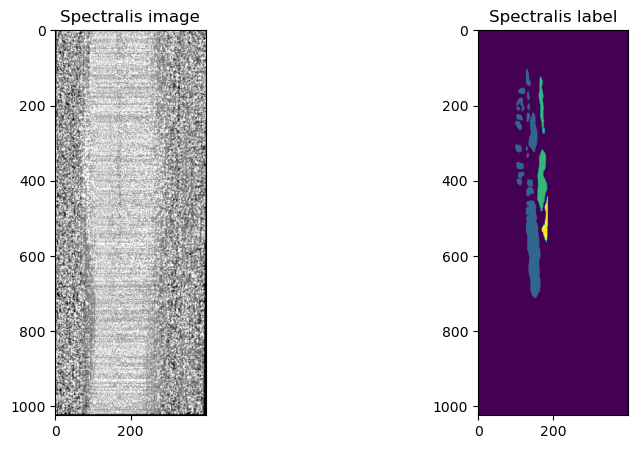

In [25]:
transforms = Compose([
    #ConvertToMultiChannelMasks(keys=['label'], target_keys=["masks"]),
    #GetMaskPositions(keys=['masks'], target_keys=["mask_positions"]), #We get the layer position, but on the original height
    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),
    ExpandChannelDim(keys=['img']),
    EnsureChannelFirstd(keys=['label'], channel_dim=2),
    TransposeImage(keys=['img', 'label']),
    Resized(keys=["img", "label"], mode=["area", "nearest-exact"], spatial_size=[-1, 400]), # We first only resize horizontally, for the correct image width
    #RandZoomd(keys=["img", "label"], mode=["area", "nearest-exact"], prob=0.3, min_zoom=0.5, max_zoom=1.5),
    #RandAxisFlipd(keys=["img", "label"], prob=0.3),
    #RandHistogramShiftd(keys=["img"], prob=0.3),
    RandAffined(keys=["img", "label"], 
                prob=0.3, 
                shear_range=[(-0.7, 0.7), (0.0, 0.0)], 
                translate_range=[(-300, 100), (0, 0)], 
                rotate_range=[20, (0, 0)],
                mode=["bilinear", "nearest"], 
                padding_mode="zeros"),
    #ToTensord(keys=['img', 'label'])
                
    #Lambdad(keys=['img','label'], func = lambda x: x[0, ...]), # this only gets the first slice of the image
    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),
    #Lambdad(keys=['mask_positions'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions
    #Lambdad(keys=['img'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)),
    #Lambdad(keys=['img'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),
])

dataset = OCTDatasetPreparation(train_dir, transform=transforms)[10]
# plot the image and label after the transforms
img = dataset['img']
label = dataset['label']
print(img.shape, label.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0], cmap='gray')
ax[0].set_title('Spectralis image')
ax[1].imshow(label[0], cmap='viridis')
ax[1].set_title('Spectralis label')
plt.show()


In [13]:
training_ready = False

run_name = 'FirstTests'

#wandb.init(project="PracticalWorkinAI", name="svdna_reproduction_retouch_only")

name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/') # directory where img folders are still sorted by domain (but unprocessed OCT images)
train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train') # already processed OCT images but unsorted by domain (sorting happens in dataset class)


# model params were not specified in SVDNA paper
model = monai.networks.nets.UNet(spatial_dims=2, 
                                 in_channels=1, 
                                 out_channels=3, 
                                 channels=(32, 64, 128, 256, 512),
                                 strides=(2, 2, 2, 2),
                                 kernel_size=3, 
                                 up_kernel_size=3, 
                                 num_res_units=2, 
                                 act='PRELU', 
                                 norm='INSTANCE', 
                                 dropout=0.0, 
                                 bias=True, 
                                 adn_ordering='NDA')

#BasicUNetPlusPlus(
#    spatial_dims=2,
#    in_channels=1,
#    out_channels=3,
#    features=(32, 64, 128, 256, 512, 1024)
#)


criterion = monai.losses.DiceLoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)


dataset = OCTDatasetPreparation(train_dir, transform=transforms)[0]
print(dataset['img'].shape)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0) # multiprocessing doesn't work??

for batch_idx, sample in enumerate(dataloader):
    print("Batch ", batch_idx)
    break
    #print("Dataloading: ", sample['img'].shape)
    #print("Dataloading label: ", sample['label'].shape)

if training_ready:

    num_epochs = 10
    for epoch in range(num_epochs):
        for batch_idx, (source_img, target_img) in enumerate(dataloader):
            optimizer.zero_grad()

            output = model(source_img)

            loss = criterion(output, target_img)

            loss.backward()
            optimizer.step()

            # log loss to wandb
            wandb.log({"Loss": loss.item(), "Epoch": epoch, "Batch": batch_idx})

            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item()}')

    # save the trained model if needed
    torch.save(model.state_dict(), f'{run_name}.pth')

    # finish wandb run
    wandb.finish()

SVD took:  0.5244021415710449  seconds
torch.Size([1, 496, 400])


KeyError: 1